In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import matplotlib
import seaborn as sns

print("sklearn versão:", sk.__version__)
print("numpy versão:", np.__version__)
print("pandas versão:", pd.__version__)
print("matplotlib versão:", matplotlib.__version__)
print("seaborn versão:", sns.__version__)

sklearn versão: 0.23.2
numpy versão: 1.16.2
pandas versão: 1.0.5
matplotlib versão: 3.0.3
seaborn versão: 0.11.0


In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df_original = pd.read_csv("CaDa_NaoLigamosParaAG_FullData.csv")
df = df_original.copy()

# Transformações dos tipos das variáveis e criação de novas

In [4]:
# boolean (true,false) to (1,0)

bool_col = ['gesticula_negociante', 'automatico_primeiro_carro', 'flex_primeiro_carro', 
 'automatico_segundo_carro', 'flex_segundo_carro',
 'automatico_carro_comprado', 'flex_carro_comprado', 'tem_criancas']

for col in bool_col:
    df[col] = df.apply(lambda x: float(x[col]), axis=1)

In [5]:
# criando variáveis de tempo

df['data']= pd.to_datetime(df['data'])

df['dia_semana']= df.apply(lambda x: x['data'].weekday(), axis=1)
df['dia_mês']= df.apply(lambda x: x['data'].day, axis=1)
df['mês']= df.apply(lambda x: x['data'].month, axis=1)
df['ano']= df.apply(lambda x: x['data'].year, axis=1)

In [6]:
# criando flag se o cliente comprou ou não naquela visita

df['comprou'] = df.apply(lambda x: int(x.notna()['valor_carro_comprado']), axis=1)

In [7]:
# id do vendedor to int

df['id_vendedor'] = df.apply(lambda x: int(x['id_vendedor'][9:11]),axis=1)

In [8]:
ordinal_col = ['idade_negociante', 'vestimenta_negociante']
ordinal_dic = [{'[18, 25)': 0, '[25, 40)': 1, '[40, 100)': 2}, 
               {'Mal-arrumado': 0, 'Normal': 1, 'Bem-arrumado': 2}]

for i, col in enumerate(ordinal_col):
    df[col] = df.apply(lambda x: ordinal_dic[i][(x[col])], axis=1)

Para tratar as nominais seguimos com duas abordagens. A primeira apenas traduziu

In [9]:
nominais_col = ['periodo_visita', 'sexo_negociante',  'cor_cabelo_negociante', 
                'cor_primeiro_carro', 'cor_segundo_carro', 'cor_carro_comprado',
                'tipo_primeiro_carro',  'tipo_segundo_carro', 'tipo_carro_comprado',
                'marca_primeiro_carro',  'marca_segundo_carro', 'marca_carro_comprado']

In [10]:
df_nom = df.copy()

nominais_dic_aux = []
nominais_col_aux = nominais_col[0:3]+[nominais_col[3]]+[nominais_col[6]]+[nominais_col[9]]
for j, col in enumerate(nominais_col_aux):
    aux_dic = {}
    for i, nome in enumerate(df_nom[col].unique()):
        aux_dic[nome] = i
    aux_dic[np.nan] = i + 1
    nominais_dic_aux.append(aux_dic)
    
nominais_dic = nominais_dic_aux[0:3]+3*[nominais_dic_aux[3]]+3*[nominais_dic_aux[4]]+3*[nominais_dic_aux[5]]

for i, col in enumerate(nominais_col):
    df_nom[col] = df_nom.apply(lambda x: nominais_dic[i][(x[col])], axis=1) 

In [11]:
# caso quisessemos usar um classificador mais geral, esse formato de get_dummies é melhor que a ordenação aleatória do df_nom,
# mas como usamos uma árvore, acabamos nem usando isso.

df_prep = df.merge(pd.get_dummies(df[nominais_col]),left_index=True, right_index=True).drop(columns=nominais_col)

# Análise temporal

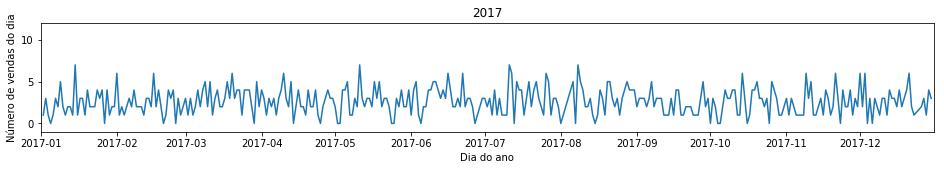

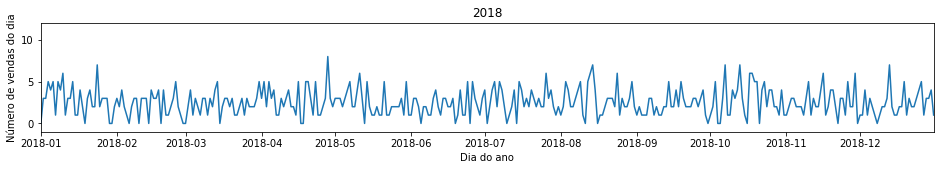

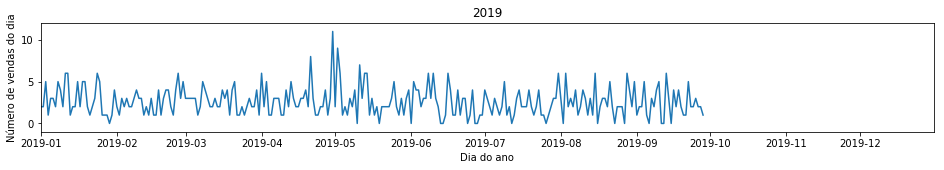

In [12]:

for ano in ['2017','2018','2019']:
    fig = plt.figure(figsize=(16,2))
    plt.plot(df.query("ano==@ano").groupby(by='data').sum()['comprou'].index, df.query("ano==@ano").groupby(by='data').sum()['comprou'].values)
    plt.ylim(-1,12)
    plt.xlim(pd.to_datetime("01-01-"+ano), pd.to_datetime("31-12-"+ano))
    plt.title(ano)
    plt.ylabel('Número de vendas do dia')
    plt.xlabel('Dia do ano')
#     plt.savefig("ano"+ano+".jpeg", bbox_inches='tight')
    plt.show()

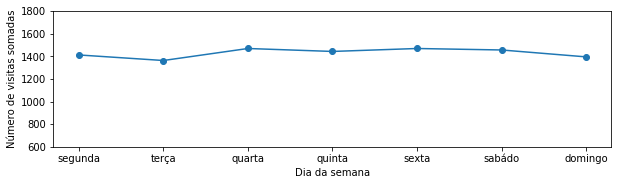

In [13]:
fig = plt.figure(figsize=(10,2.5))
plt.plot(df.groupby(by='dia_semana').count()['comprou'].index, df.groupby(by='dia_semana').count()['comprou'].values, marker='o')
plt.xticks(range(7),labels=['segunda', 'terça', 'quarta', 'quinta', 'sexta', 'sabádo', 'domingo'])
plt.ylabel('Número de visitas somadas')
plt.xlabel('Dia da semana')
plt.ylim(600,1800)
plt.savefig("semana.jpeg", bbox_inches='tight')
plt.show()

The dayofweek property is used to get the day of the week.

The day of the week with Monday=0, Sunday=6.

# Apontando inconsistência encontrada da base

In [14]:
table = pd.pivot_table(df, values='data', index=['nro_pessoas'],
                    columns=['tem_criancas'], aggfunc='count', margins=True)
table

tem_criancas,0.0,1.0,All
nro_pessoas,,,
1,248,5559,5807
2,1995,123,2118
3,822,54,876
4,457,31,488
5,671,40,711
All,4193,5807,10000


Optaremos por usar apenas as variáveis de `tem_criancas` no modelo final explorado com detalhe na metodologia.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_score, f1_score, accuracy_score, recall_score, roc_auc_score, confusion_matrix

In [16]:
variaveis_cliente = ['loja', 'vestimenta_negociante', 'sexo_negociante', 
                     'cor_cabelo_negociante', 'gesticula_negociante', 'idade_negociante',
                     'tem_criancas', 'periodo_visita']  # 'nro_pessoas'

In [17]:
X = df_nom[variaveis_cliente]
y = df['comprou']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [18]:
rfc = RandomForestClassifier(oob_score=True, max_depth=20)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, oob_score=True)

Avaliando modelo

In [19]:
print(accuracy_score(y_test, rfc.predict(X_test)))
print(f1_score(y_test, rfc.predict(X_test)))
print(recall_score(y_test, rfc.predict(X_test)))
print(precision_score(y_test,rfc.predict(X_test)))
print(roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]))

0.828
0.6187943262411347
0.5487421383647799
0.709349593495935
0.803862745296515


In [20]:
confusion_matrix(y_test,rfc.predict(X_test))

array([[1721,  143],
       [ 287,  349]], dtype=int64)

In [21]:
rfc.oob_score_

0.8202666666666667

In [22]:
1- y_test.mean()

0.7456

Não é nada demais, mas aprendeu algo.

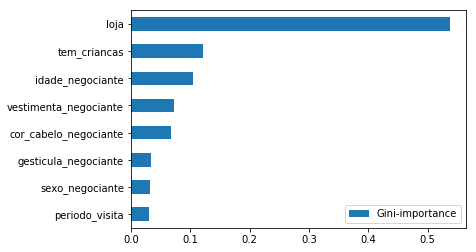

In [23]:
# código dessa célula: http://quoc3912830.blogspot.com/2018/08/mapping-column-names-to-random-forest.html

feats = {} 
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=True).plot.barh()
plt.savefig("gini.jpeg", bbox_inches='tight')
plt.show()

## crianças

In [24]:
table = pd.pivot_table(df, values='gesticula_negociante', index=['tem_criancas'],
                    columns=['comprou'], aggfunc='count', margins=True)
table2 = table.div( table.iloc[:,-1], axis=0 )
table

comprou,0,1,All
tem_criancas,,,
0.0,3684,509,4193
1.0,3717,2090,5807
All,7401,2599,10000


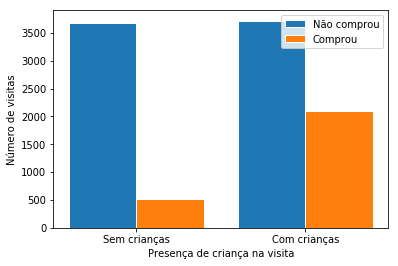

In [25]:
# código adaptado de https://python-graph-gallery.com/11-grouped-barplot/

# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = [3684, 3717]
bars2 = [509, 2090]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Não comprou')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Comprou')
 
# Add xticks on the middle of the group bars
plt.xlabel('Presença de criança na visita')
plt.ylabel('Número de visitas')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['Sem crianças', 'Com crianças'])
 
# Create legend & Show graphic
plt.legend()
plt.savefig("grafico_criancas.jpeg", bbox_inches='tight')
plt.show()


## idade_negociante

In [26]:
table = pd.pivot_table(df, values='gesticula_negociante', index=['idade_negociante'],
                    columns=['comprou'], aggfunc='count', margins=True)
table2 = table.div( table.iloc[:,-1], axis=0 )
table

comprou,0,1,All
idade_negociante,,,
0,2176,306,2482
1,3000,1547,4547
2,2225,746,2971
All,7401,2599,10000


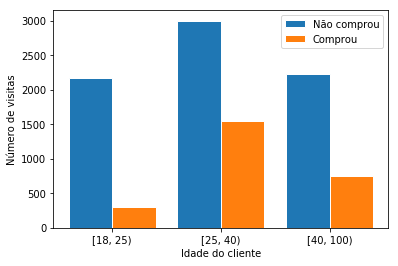

In [27]:
# código adaptado de https://python-graph-gallery.com/11-grouped-barplot/

# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = [2176, 3000, 2225]
bars2 = [306, 1547, 746]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Não comprou')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Comprou')
 
# Add xticks on the middle of the group bars
plt.xlabel('Idade do cliente')
plt.ylabel('Número de visitas')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['[18, 25)', '[25, 40)', '[40, 100)'])
 
# Create legend & Show graphic
plt.legend()
plt.savefig("grafico_idades.jpeg", bbox_inches='tight')
plt.show()

## vestimenta

In [28]:
table = pd.pivot_table(df, values='gesticula_negociante', index=['vestimenta_negociante'],
                    columns=['comprou'], aggfunc='count', margins=True)
table2 = table.div( table.iloc[:,-1], axis=0 )
table

comprou,0,1,All
vestimenta_negociante,,,
0,2207,561,2768
1,3098,1508,4606
2,2096,530,2626
All,7401,2599,10000


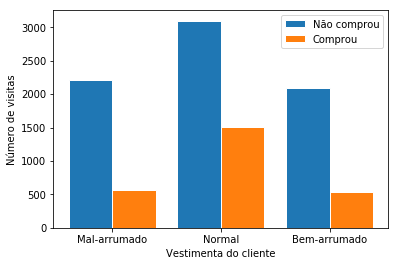

In [29]:
# código adaptado de https://python-graph-gallery.com/11-grouped-barplot/

# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = [2207, 3098, 2096]
bars2 = [561, 1508, 530]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Não comprou')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Comprou')
 
# Add xticks on the middle of the group bars
plt.xlabel('Vestimenta do cliente')
plt.ylabel('Número de visitas')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['Mal-arrumado', 'Normal', 'Bem-arrumado'])
 
# Create legend & Show graphic
plt.legend()
plt.savefig("grafico_vestimenta.jpeg", bbox_inches='tight')
plt.show()

## loja

In [30]:
table = pd.pivot_table(df, values='gesticula_negociante', index=['loja'],
                    columns=['comprou'], aggfunc='count', margins=True)
table2 = table.div( table.iloc[:,-1], axis=0 )
table

comprou,0,1,All
loja,,,
1,2638,370,3008
2,3581,457,4038
3,1010,939,1949
4,172,833,1005
All,7401,2599,10000


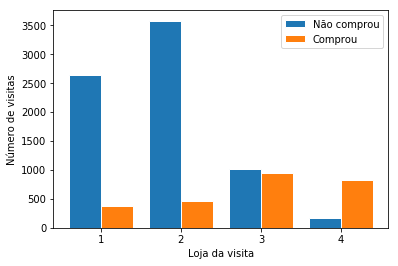

In [31]:
# código adaptado de https://python-graph-gallery.com/11-grouped-barplot/

# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = [2638, 3581, 1010, 172]
bars2 = [370, 457, 939, 833]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Não comprou')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Comprou')
 
# Add xticks on the middle of the group bars
plt.xlabel('Loja da visita')
plt.ylabel('Número de visitas')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['1', '2', '3', '4'])
 
# Create legend & Show graphic
plt.legend()
plt.savefig("grafico_loja.jpeg", bbox_inches='tight')
plt.show()

Imaginamos que o púlbico que visita cada uma das lojas é um pouco diferente. Sera que a presença de crianças discrimina bem a loja?

In [32]:
table = pd.pivot_table(df, values='gesticula_negociante', index=['loja'],
                    columns=['tem_criancas'], aggfunc='count', margins=True)
table2 = table.div( table.iloc[:,-1], axis=0 )
table

tem_criancas,0.0,1.0,All
loja,,,
1,1397,1611,3008
2,1851,2187,4038
3,666,1283,1949
4,279,726,1005
All,4193,5807,10000


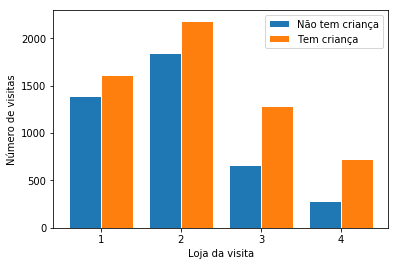

In [33]:
# código adaptado de https://python-graph-gallery.com/11-grouped-barplot/

# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = [1397, 1851, 666, 279]
bars2 = [1611, 2187, 1283, 726]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Não tem criança')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Tem criança')
 
# Add xticks on the middle of the group bars
plt.xlabel('Loja da visita')
plt.ylabel('Número de visitas')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['1', '2', '3', '4'])
 
# Create legend & Show graphic
plt.legend()
plt.savefig("grafico_loja_crianca.jpeg", bbox_inches='tight')
plt.show()

____

In [35]:
# criando flag se o cliente olhou 2 carros

df['olhou_segundo'] = df.apply(lambda x: int(x.notna()['valor_segundo_carro']), axis=1)

In [36]:
table = pd.pivot_table(df, values='gesticula_negociante', index=['olhou_segundo'],
                    columns=['comprou'], aggfunc='count', margins=True)
table

comprou,0,1,All
olhou_segundo,,,
0,2453,847,3300
1,4948,1752,6700
All,7401,2599,10000


In [37]:
table2 = table.div( table.iloc[:,-1], axis=0 )
table2

comprou,0,1,All
olhou_segundo,,,
0,0.743333,0.256667,1.0
1,0.738507,0.261493,1.0
All,0.740100,0.259900,1.0
